In [1]:
import dynalearn as dl
import h5py
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import tensorflow.keras as keras
from time import time
import tqdm
import os

In [71]:
# Graph parameters

np_seed = int(time())
tf_seed = int(time() + 10)
np.random.seed(np_seed)
tf.set_random_seed(tf_seed)

N = 100
avgk = 10
graph_model = dl.graphs.ERGraph(N, avgk / N, np_seed)

# Dynamics parameters
inf_prob = 0.04
rec_prob = 0.1
init_state = None
dynamics_model = dl.dynamics.SISDynamics(inf_prob, rec_prob, init_state)



# Data generator parameters
batch_size = 32
shuffle = True
prohibited_node_index=[],
max_null_iter=100
T = 200
num_sample = 5000
gamma = 0.
data_generator = dl.generators.MarkovBinaryDynamicsGenerator(graph_model, dynamics_model,
                                                             batch_size,
                                                             shuffle=shuffle, 
                                                             prohibited_node_index=prohibited_node_index,
                                                             max_null_iter=max_null_iter)

# Model parameters
n_hidden = [32, 32, 32]
n_heads = 3
wd = 1e-4
dropout = 0.
model = dl.models.GATMarkovBinaryPredictor(N,
                                           2,
                                           n_hidden,
                                           n_heads,
                                           weight_decay=wd,
                                           dropout=dropout,
                                           seed=tf_seed)

# Trainer parameters
loss = keras.losses.categorical_crossentropy
optimizer = keras.optimizers.Adam()
metrics = ['accuracy']
learning_rate=1e-4
callbacks = []

exp = dl.Experiment("test", model, data_generator,
                    loss=loss,
                    optimizer=optimizer,
                    metrics=metrics,
                    learning_rate=learning_rate,
                    callbacks=callbacks,
                    numpy_seed=np_seed,
                    tensorflow_seed=tf_seed)
print(model.model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
graph_attention_5 (GraphAttenti [(None, 96), (None,  384         input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 96)           384         graph_attention_5[0][0]          
__________

In [72]:
# Generating data for training
exp.generate_data(num_sample, T, gamma=gamma, progress_bar=tqdm.tqdm_notebook)

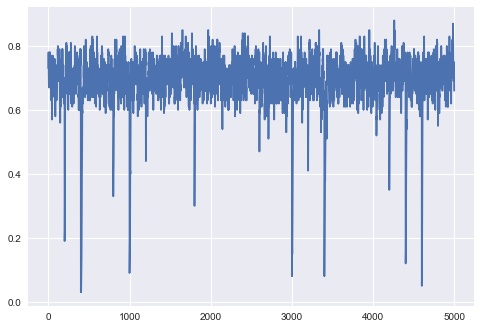

In [73]:
plt.plot(np.mean(exp.data_generator.targets["ERGraph_0"], 1))
plt.show()


In [89]:
# Training model

exp.train_model(30, 1000, verbose=1)

h5file = h5py.File('experiment_1.h5', 'w')
exp.save_hdf5_all(h5file)
h5file.close()

Epoch 21/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4162 - acc: 0.8574

In [90]:
adj = exp.data_generator.graph_inputs["ERGraph_0"]
graph = nx.from_numpy_array(adj)
x = exp.data_generator.state_inputs["ERGraph_0"]
y = exp.data_generator.targets["ERGraph_0"]

real = dynamics_model.ltp(x)
estimator = dynamics_model.estimate_ltp(x, y)
prediction = dynamics_model.model_ltp(exp.model.model, x)

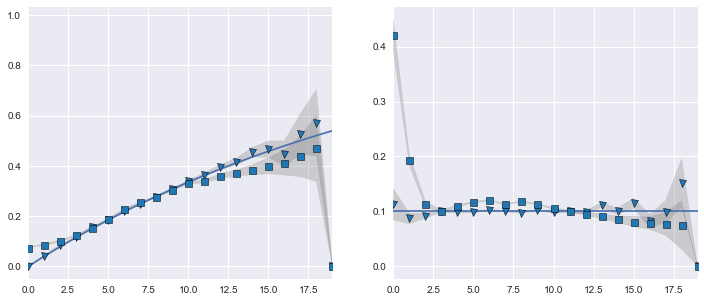

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
k = np.arange(adj.shape[0])

in_state, out_state = 'S', 'I'
ax[0].plot(k, real[(in_state, out_state)])
ax[0].plot(k, estimator[0][(in_state, out_state)], marker='v', linestyle='none', color='#1f77b4',
           markeredgecolor="k", markeredgewidth=0.5)
ax[0].fill_between(k,
                   estimator[0][(in_state, out_state)] - estimator[1][(in_state, out_state)],
                   estimator[0][(in_state, out_state)] + estimator[1][(in_state, out_state)],
                   color='grey', alpha=0.3)
ax[0].plot(k, prediction[0][(in_state, out_state)], marker='s', linestyle='none', color='#1f77b4',
           markeredgecolor="k", markeredgewidth=0.5)
ax[0].fill_between(k,
                   prediction[0][(in_state, out_state)] - estimator[1][(in_state, out_state)],
                   prediction[0][(in_state, out_state)] + estimator[1][(in_state, out_state)],
                   color='grey', alpha=0.3)
ax[0].set_xlim([0, max(np.sum(adj, 1))])

in_state, out_state = 'I', 'S'
ax[1].plot(k, real[(in_state, out_state)])
ax[1].plot(k, estimator[0][(in_state, out_state)], marker='v', linestyle='none', color='#1f77b4',
           markeredgecolor="k", markeredgewidth=0.5)
ax[1].fill_between(k,
                   estimator[0][(in_state, out_state)] - estimator[1][(in_state, out_state)],
                   estimator[0][(in_state, out_state)] + estimator[1][(in_state, out_state)],
                   color='grey', alpha=0.3)
ax[1].plot(k, prediction[0][(in_state, out_state)], marker='s', linestyle='none', color='#1f77b4',
           markeredgecolor="k", markeredgewidth=0.5)
ax[1].fill_between(k,
                   prediction[0][(in_state, out_state)] - estimator[1][(in_state, out_state)],
                   prediction[0][(in_state, out_state)] + estimator[1][(in_state, out_state)],
                   color='grey', alpha=0.3)
ax[1].set_xlim([0, max(np.sum(adj, 1))])
plt.show()

In [98]:
attn1 = model.get_attn_layer(1)
attn2 = model.get_attn_layer(2)
attn3 = model.get_attn_layer(3)


In [105]:
def process_attn_coeff(attn_model, states, adj):
    cond_attn = {('S', 'S'): [],
                 ('S', 'I'): [],
                 ('I', 'S'): [],
                 ('I', 'I'): []}
    for s in states:
        _attn_coeff = attn_model.predict([s, adj], steps=1)
        s = s.reshape(s.shape[0], 1)
        s_s_state_matrix = np.matmul(1 - s, (1 - s).T) * adj
        s_i_state_matrix = np.matmul(1 - s, s.T) * adj
        i_s_state_matrix = np.matmul(s, (1 - s).T) * adj
        i_i_state_matrix = np.matmul(s, s.T) * adj
        cond_attn[('S', 'S')].extend(_attn_coeff[s_s_state_matrix == 1])
        cond_attn[('S', 'I')].extend(_attn_coeff[s_i_state_matrix == 1])
        cond_attn[('I', 'S')].extend(_attn_coeff[i_s_state_matrix == 1])
        cond_attn[('I', 'I')].extend(_attn_coeff[i_i_state_matrix == 1])
    
    return cond_attn
        
        
        
    

In [106]:
cond_attn1 = process_attn_coeff(attn1, x, adj)
cond_attn2 = process_attn_coeff(attn2, x, adj)
cond_attn3 = process_attn_coeff(attn3, x, adj)

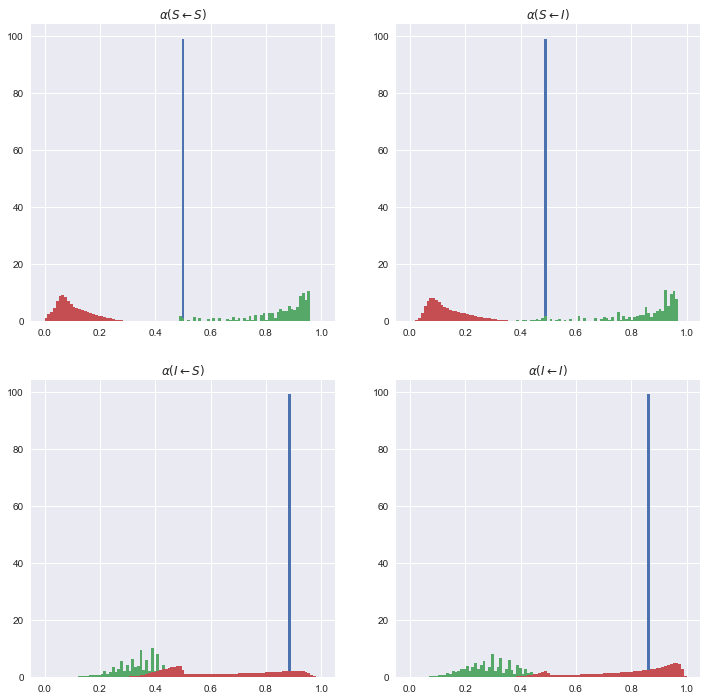

In [109]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0,0].hist(cond_attn1[('S', 'S')], bins=np.linspace(0, 1, 100), density=True)
ax[0,1].hist(cond_attn1[('S', 'I')], bins=np.linspace(0, 1, 100), density=True)
ax[1,0].hist(cond_attn1[('I', 'S')], bins=np.linspace(0, 1, 100), density=True)
ax[1,1].hist(cond_attn1[('I', 'I')], bins=np.linspace(0, 1, 100), density=True)

ax[0,0].hist(cond_attn2[('S', 'S')], bins=np.linspace(0, 1, 100), density=True)
ax[0,1].hist(cond_attn2[('S', 'I')], bins=np.linspace(0, 1, 100), density=True)
ax[1,0].hist(cond_attn2[('I', 'S')], bins=np.linspace(0, 1, 100), density=True)
ax[1,1].hist(cond_attn2[('I', 'I')], bins=np.linspace(0, 1, 100), density=True)

ax[0,0].hist(cond_attn3[('S', 'S')], bins=np.linspace(0, 1, 100), density=True)
ax[0,1].hist(cond_attn3[('S', 'I')], bins=np.linspace(0, 1, 100), density=True)
ax[1,0].hist(cond_attn3[('I', 'S')], bins=np.linspace(0, 1, 100), density=True)
ax[1,1].hist(cond_attn3[('I', 'I')], bins=np.linspace(0, 1, 100), density=True)

ax[0, 0].set_title(r'$\alpha(S\leftarrow S)$')
ax[0, 1].set_title(r'$\alpha(S\leftarrow I)$')
ax[1, 0].set_title(r'$\alpha(I\leftarrow S)$')
ax[1, 1].set_title(r'$\alpha(I\leftarrow I)$')

plt.show()